# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Dataset generation

* Data set contain images of size 100px X 100px ,having 2 blobs of color red and blue , randomly place in the black background of the image.
* This generates 1000 images  and a csv file with images path and coordinates of each blob in the image.
* Image size, color of the image, size of the bolbs, color of the blobs , number of images - all are customisable.

(Blobs are small patches of color in the black background, of which we would predict the coordinates)

In [2]:
import cv2
import numpy as np
import pandas as pd
import random
import os

def generate_image_and_label(image_size,dia,):
    image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    point1_color = (0, 0, 255)   # Red
    point2_color = (255, 0, 0)   # Blue
    point3_color = (0, 255, 0)   # Green

    point1_coords = (random.randint(0, image_size[1]-(dia/2)), random.randint(0, image_size[0]-(dia/2)))
    point2_coords = (random.randint(0, image_size[1]-(dia/2)), random.randint(0, image_size[0]-(dia/2)))
    point3_coords = (random.randint(0, image_size[1]-(dia/2)), random.randint(0, image_size[0]-(dia/2)))

    cv2.circle(image, point1_coords, dia, point1_color, -1)
    cv2.circle(image, point2_coords, dia, point2_color, -1)
    cv2.circle(image, point3_coords, dia, point3_color, -1)

    label = {
        'image_Name': f'image_{i+1}.png',
        'Point1_X': point1_coords[0],
        'Point1_Y': point1_coords[1],
        'Point2_X': point2_coords[0],
        'Point2_Y': point2_coords[1],
        'Point3_X': point3_coords[0],
        'Point3_Y': point3_coords[1]
    }

    return image, label

num_images = 1500
output_folder = '3_blob_data'
csv_filename = 'labels.csv'
image_size = (100,100)
dia = 4

os.makedirs(output_folder, exist_ok=True)

labels_list = []

for i in range(num_images):
    image, label = generate_image_and_label(image_size,dia)

    image_filename = f'image_{i+1}.png'
    cv2.imwrite(os.path.join(output_folder, image_filename), image)

    labels_list.append(label)

labels_df = pd.DataFrame(labels_list)
labels_df.to_csv(os.path.join(output_folder, csv_filename), index=False)

print(f'Dataset generated: {num_images} images and labels saved in {output_folder}')


Dataset generated: 1500 images and labels saved in 3_blob_data


# CSV file

In [3]:
path = '3_blob_data'
df = pd.read_csv(os.path.join(path,'labels.csv'))
df.head()

,image_Name,Point1_X,Point1_Y,Point2_X,Point2_Y,Point3_X,Point3_Y
0,image_1.png,72,9,66,8,9,55
1,image_2.png,53,92,77,35,75,76
2,image_3.png,64,81,48,36,7,45
3,image_4.png,38,34,74,74,54,27
4,image_5.png,39,66,12,40,83,56


# Image processing

* Load the image and change to the target size
* Convert the image to array
* Noramlize the image px values by dividing by 255

In [4]:
df_name = df['image_Name']
imgs = []
def load_and_preprocess_image(image_path,target_size=(100,100)):
    img = load_img(image_path,target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img) / 255.0
    img_array = img_array.reshape((1,) + img_array.shape)
    return img_array

for i in range(len(df_name)):
    image_path = os.path.join(path,df_name[i])
    img_array = load_and_preprocess_image(image_path)
    imgs.append(img_array)

imgs = np.vstack(imgs)
imgs.shape

(1500, 100, 100, 3)

## Labels - coordinated of the blobs

In [5]:
labels = df[['Point1_X','Point1_Y','Point2_X','Point2_Y','Point3_X','Point3_Y']].values
labels.shape

(1500, 6)

# Train- Validation Split

* Split in the ration 9:1 , i.e 1350 train images and 150 validation images

In [6]:
X_train, X_val, y_train, y_val = train_test_split(imgs, labels, test_size=0.1, random_state=42)

# CNN

* Conv-layer -> Maxpooling -> Dropout , these layers are implemented 4 times
* followed by Flattening and producing final 6 outputs

In [7]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Conv2D(filters=32,kernel_size= (3, 3), activation='relu', padding='same',input_shape=(100, 100, 3)),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(filters=64,kernel_size= (3, 3), activation='relu', padding='same'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),
    Conv2D(128, (3, 3),  padding='same',activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1, 1)),
    Dropout(0.1),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1, 1)),
    Dropout(0.1),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(6)
])

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 restore_best_weights=True)
reduce_learning=tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                     factor=0.2,
                                     verbose=0,
                                     patience=5,
                                     min_lr=0.000001,
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      40,960,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,350,214 (157.74 MB)

 Trainable params: 41,350,214 (157.74 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_learning],
    verbose=1
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - loss: 1669.6136 - mae: 32.6882 - val_loss: 605.9886 - val_mae: 20.3692 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 580.5500 - mae: 19.6469 - val_loss: 561.5656 - val_mae: 19.6293 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 494.4166 - mae: 18.0308 - val_loss: 294.1029 - val_mae: 12.6209 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 183.5405 - mae: 9.9037 - val_loss: 66.9594 - val_mae: 5.9097 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 51.4769 - mae: 5.1991 - val_loss: 59.0355 - val_mae: 5.6923 - learning_rate: 0.0010
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 37.6923 - mae: 4.3825 - val_loss: 36.3235 - val_mae: 4.2617 - learning_rate: 0.0010
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 26.5203 - mae: 3.6890 - val_loss: 36.2810 - val_mae: 4.3716 - learn

# Train - Validation loss

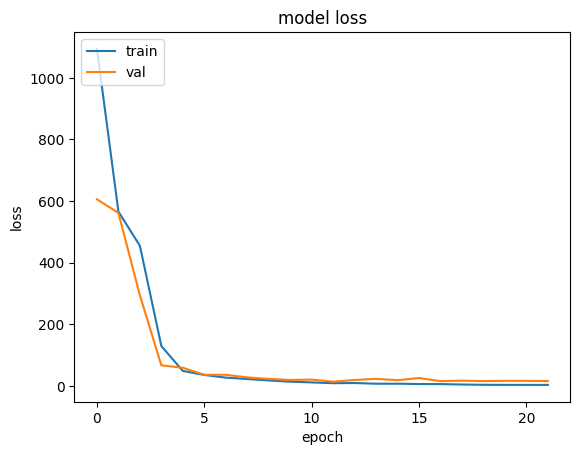

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')



### Last 15 training epoch , to show that the training hasn't plateaued , but close to plateauing

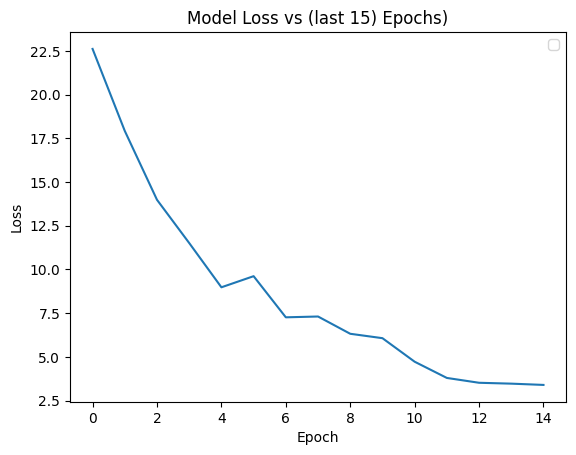

In [10]:
plt.plot(history.history['loss'][-15:])
plt.title('Model Loss vs (last 15) Epochs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Testing the Model

* generate a new images , preprocess and give to the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


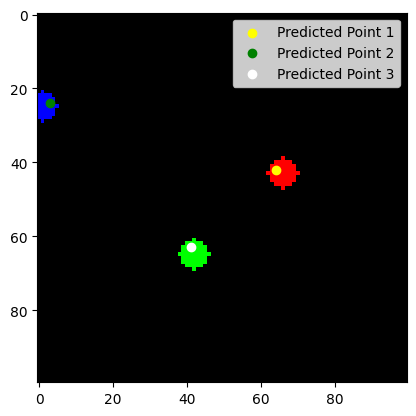

In [13]:
image,label = generate_image_and_label((100,100),4)
import tempfile
with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmpfile:
    image_path = tmpfile.name
    cv2.imwrite(image_path, image)

    image = load_and_preprocess_image(image_path)

predicted_points = model.predict(image)

image_display = image[0] * 255
image_display = image_display.astype('uint8')

p1_x = int(predicted_points[0][0])
p1_y = int(predicted_points[0][1])
p2_x = int(predicted_points[0][2])
p2_y = int(predicted_points[0][3])
p3_x = int(predicted_points[0][4])
p3_y = int(predicted_points[0][5])


plt.imshow(image_display)
plt.scatter(p1_x, p1_y, color='yellow', label='Predicted Point 1')
plt.scatter(p2_x, p2_y, color='green', label='Predicted Point 2')
plt.scatter(p3_x, p3_y, color='white', label='Predicted Point 3')

plt.legend()
plt.show()

* Image of the prediction on the actual image
* Error calculated as :  $   
\text{Error (%)} = \left( \frac{\text{Absolute Difference}}{\text{Actual Value}} \right) \times 100
$

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


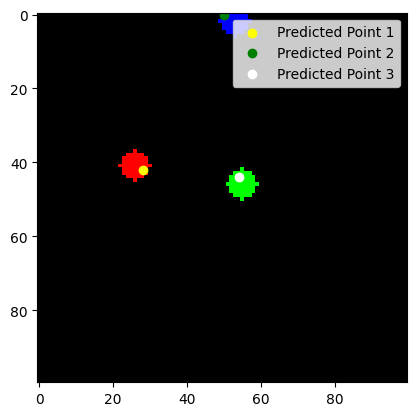

Predicted Points: [28, 42, 50, 0, 54, 44]
Actual Label: [26, 41, 53, 2, 55, 46]
Error Point 1 X: 7.69 %
Error Point 1 Y: 2.44 %
Error Point 2 X: 5.66 %
Error Point 2 Y: 100.00 %
Error Point 3 X: 1.82 %
Error Point 3 Y: 4.35 %


In [12]:
image,label = generate_image_and_label((100,100),4)
import tempfile
with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmpfile:
    image_path = tmpfile.name
    cv2.imwrite(image_path, image)

    image = load_and_preprocess_image(image_path)

predicted_points = model.predict(image)

image_display = image[0] * 255
image_display = image_display.astype('uint8')

p1_x = int(predicted_points[0][0])
p1_y = int(predicted_points[0][1])
p2_x = int(predicted_points[0][2])
p2_y = int(predicted_points[0][3])
p3_x = int(predicted_points[0][4])
p3_y = int(predicted_points[0][5])


plt.imshow(image_display)
plt.scatter(p1_x, p1_y, color='yellow', label='Predicted Point 1')
plt.scatter(p2_x, p2_y, color='green', label='Predicted Point 2')
plt.scatter(p3_x, p3_y, color='white', label='Predicted Point 3')

plt.legend()
plt.show()

import numpy as np

predicted_points = [p1_x, p1_y, p2_x, p2_y, p3_x, p3_y]

actual_points = [label["Point1_X"], label["Point1_Y"], label["Point2_X"], label["Point2_Y"], label["Point3_X"], label["Point3_Y"]]

print("Predicted Points:", predicted_points)
print("Actual Label:", actual_points)

diff_p1x = np.abs(p1_x - label["Point1_X"])
diff_p1y = np.abs(p1_y - label["Point1_Y"])
diff_p2x = np.abs(p2_x - label["Point2_X"])
diff_p2y = np.abs(p2_y - label["Point2_Y"])
diff_p3x = np.abs(p3_x - label["Point3_X"])
diff_p3y = np.abs(p3_y - label["Point3_Y"])

epsilon = 1e-7

relative_diff_p1x = diff_p1x / (label["Point1_X"] + epsilon)
relative_diff_p1y = diff_p1y / (label["Point1_Y"] + epsilon)
relative_diff_p2x = diff_p2x / (label["Point2_X"] + epsilon)
relative_diff_p2y = diff_p2y / (label["Point2_Y"] + epsilon)
relative_diff_p3x = diff_p3x / (label["Point3_X"] + epsilon)
relative_diff_p3y = diff_p3y / (label["Point3_Y"] + epsilon)

print(f"Error Point 1 X: {relative_diff_p1x*100 :.2f} %")
print(f"Error Point 1 Y: {relative_diff_p1y*100 :.2f} %")
print(f"Error Point 2 X: {relative_diff_p2x*100 :.2f} %")
print(f"Error Point 2 Y: {relative_diff_p2y*100 :.2f} %")
print(f"Error Point 3 X: {relative_diff_p3x*100 :.2f} %")
print(f"Error Point 3 Y: {relative_diff_p3y*100 :.2f} %")
